# Step 5.5: Deep Learning - Autoencoder (ConvNet)

In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm

import tensorflow.keras as keras

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [5]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

## Scaling the data

The data are already scaled at 550 nm. However, in our case we re-scale all spectra from 0 to 1. Due to the already present pre-processing, no exhaustive processing is needed.

In [6]:
# Scale the training and test data
X_train_scaled = np.array([(k - np.min(k)) / (np.max(k - np.min(k)))  for k in X_train])
X_test_scaled = np.array([(k - np.min(k)) / (np.max(k - np.min(k)))  for k in X_test])

In [7]:
n_inputs = asteroids_X.shape[1]
print(f"Number of inputs: {n_inputs}")
print(asteroids_X.shape)

Number of inputs: 49
(1339, 49)


## Building the Autoencoder

Our Autoencoder will consist of 1 input and 2 output layer. 2 hidden layers for the encoder and decoder part, respectively, and 1 latent space layer (the final encoder that has the low dimensional representation of our data).

The input data has a dimensionality of 49. The first layer reduces the number by a factor of 2 and afterwards again by a factor of 3. The encoder part shall then only have 2 values to represent the asteroid spectra. Such a reduction is quite "irresponsible"... reducing a complex data problem to 2 data points is a little bit ambitious. However, in our case we would like to have a visual representation of possible "asteroid spectra cluster" in a human-readable and -understandable way: on a simple 2D plane.

In [12]:
# Let's create an autoencoder
n_bottleneck = 2

# Input layer
in_layer = keras.layers.Input(shape=(1,n_inputs))

# First hidden layer (encoder side)
enc_hid_lay1 = keras.layers.Conv1D(32, 3, activation="relu", padding="same")(in_layer)
enc_hid_lay1 = keras.layers.MaxPooling1D(2)(enc_hid_lay1)

# Second hidden layer (encoder side)
#enc_hid_lay2 = keras.layers.Conv1D(32, 3, activation="relu", padding="same")(enc_hid_lay1)
#enc_hid_lay2 = keras.layers.MaxPooling1D(2)(enc_hid_lay2)

# Encoder ("Bottleneck" of the Autoencoder)
bottleneck_lay = keras.layers.Conv1D(2, 3, activation="relu", padding="same")(enc_hid_lay2)
bottleneck_lay = keras.layers.MaxPooling1D(2)(bottleneck_lay)
#bottleneck_lay = keras.layers.Dense(n_bottleneck, activation='linear')(enc_hid_lay2)
#bottleneck_lay = keras.layers.BatchNormalization()(bottleneck_lay)

# First hidden layer (decoder side)
dec_hid_lay1 = keras.layers.Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(bottleneck_lay)
dec_hid_lay2 = keras.layers.Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(dec_hid_lay1)

# Second hidden layer (decoder side)

# Ouput layer (same size as input layer)
out_layer = keras.layers.Conv1D(1, 3, activation="sigmoid", padding="same")(dec_hid_lay2)

# Create model
model = keras.models.Model(inputs=in_layer, outputs=out_layer)

# Compile the model. Use the Mean Squred Error as the loss function. Background: An Autoencoder is a regression function
# that maps the input value directly to the output values
model.compile(optimizer='adam', loss='mse')

# Train the model
end_epoch = 100
batch_size = 32
history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_data=(X_test_scaled, X_test_scaled))

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d/ExpandDims)' with input shapes: [?,1,1,32].

## The loss function

Let's show the loss of the training and test data. As you can see, the minimum-plateau is reached quite fast. The test data performs slightly better than the training data, since the loss results for the training data are based on an average of the batch size. The test results are based on all data.

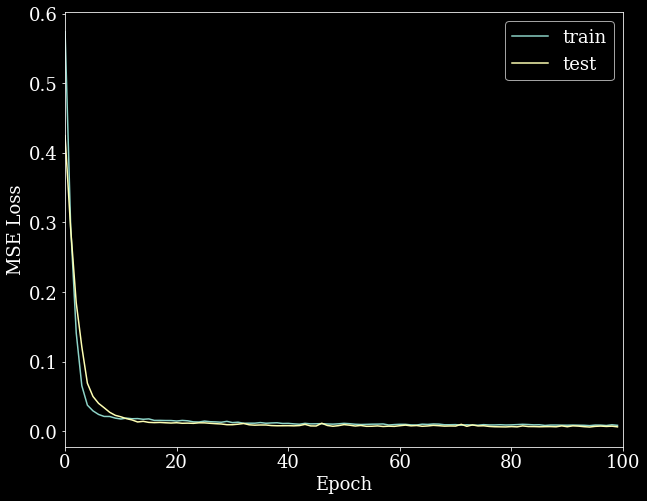

In [10]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Limit the x axis
plt.xlim(0, end_epoch)

# ... aaaaand plot!
plt.show()

## Signal Reconstruction

... can be done by using the entire model to predict the output spectra. The following code snippet takes a signal (change the index value in the first line to use any other signal) and predicts the Autoencoder based spectrum.

As one can see, the results are "quite ok" but far from perfect. The shape of the spectra can be reproduced. However, the signals are quite noisy. The question is now: Do we have a low-dimensional clustering?

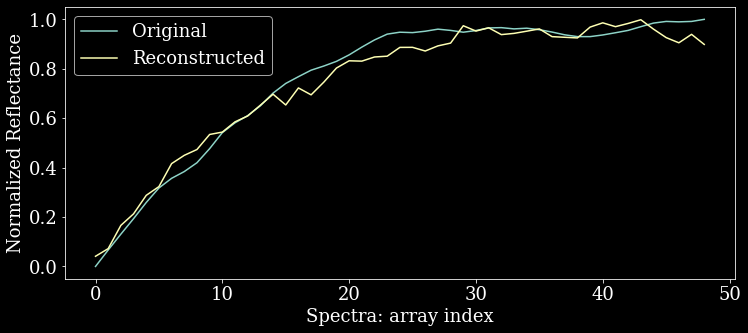

In [12]:
# Which index shall be displayed?
index_val = 0

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(X_train_scaled[index_val], label='Original')
plt.plot(model.predict(X_train_scaled)[index_val], label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [13]:
# Create dataframe that contains the encoder values (2 values at bottleneck) and the corresponding
# class to see whether the autoencoder values cluster in a way

# Build the encoder
encoder = keras.models.Model(inputs=in_layer, outputs=bottleneck_lay)

# Encode the trained spectra
X_train_encoded = encoder.predict(X_train_scaled)

# Create the dataframe
encoded_train_df = pd.DataFrame(np.hstack((X_train_encoded, y_train[np.newaxis].transpose())),
                                columns=["enc1", "enc2", "class"])

# Change the dtype to float
encoded_train_df.loc[:, "enc1"] = encoded_train_df["enc1"].astype(float)
encoded_train_df.loc[:, "enc2"] = encoded_train_df["enc2"].astype(float)

## Low Dimensional Space

Now let's take a look at the 2D Autoencoder space. The main group classes are colored and afterwards plotted. One can see that the C and S class can be distinguished well. The C Class shows also local clusters that would be investigated further. The group "other" (outlier) are separated from the rest in two "regions" and the X class overlaps with the S and C class.

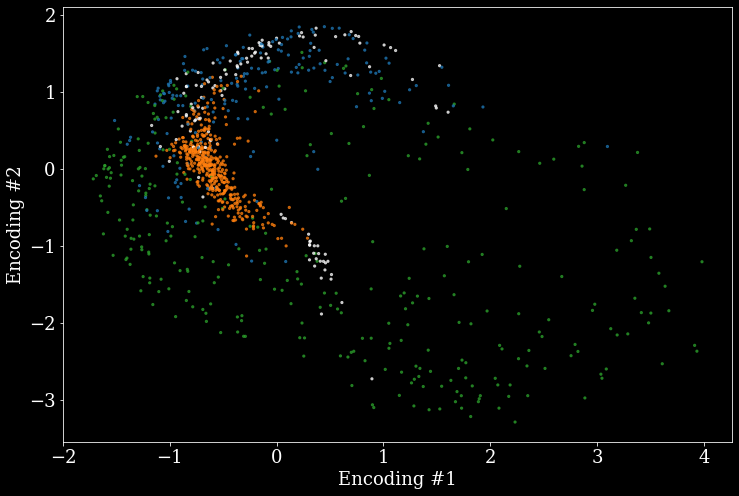

In [14]:
# Plot now the autoencoder values

# Create a dictionary to color the classes
color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encoder values and assign the colors to the corresponding classes
plt.scatter(encoded_train_df["enc1"],
            encoded_train_df["enc2"],
            marker='o',
            s=5,
            alpha=0.7,
            color=encoded_train_df.apply(lambda x: color_dict.get(x["class"]), axis=1).values)

# Set xlabels
plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

# Save the image and show it, too
plt.savefig("asteroid_spectra_AE_FF_2dim.png")
plt.show()

## Summary & Outlook

The feed-forward 2D Autoencoder showed interesting results and a low dimensional representation and even clustering (!) of the spectra. Compressing 49D to 2D results in some information loss, however, one can easily change the size of the bottleneck layer.

Next steps could be:
- Perform clustering algorithms on the 2D space
- Create an Autoencoder with convolutional 1D nets.

The second point will be performed in script 5_5!